# A2DI - TP4

## Exo 1 - Comparaison de classifieurs

(Question 1)

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

# Permet l'affichage des graphiques

%matplotlib inline

# Variable utiles

nb_features = 64

data=datasets.load_digits()
X=data.data
X=X.T
c=data.target

(Question 2)

In [2]:
def extract_56():
    X1 = []
    c1 = []
    for i in range(len(c)):
        if c[i] == 5 or c[i] == 6:
            X1.append(data.data[i])
            c1.append(data.target[i])
    return np.array(X1).T, np.array(c1)

X1, c1 = extract_56()

(Question 3)

In [3]:
c1 = np.sign(c1-np.mean(c1))

(Question 4)

In [7]:
def kfold_data(X, c, k):
    x = np.array(X).T

    # On trie les 1 et les -1
    arplus = []
    arless = []
    
    for i in range(len(x)):
        if c[i] == 1:
            arplus.append(x[i])
        else:
            arless.append(x[i])

    # On calcule la taille des plis
    size_plus = len(arplus)//k
    rest_plus = len(arplus)%k

    size_less = len(arless)//k
    rest_less = len(arless)%k
    
    # On crée tous les plis
    k_plis = []

    for i in range(k):
        x = arplus[i*size_plus:(i+1)*size_plus] + arless[i*size_less:(i+1)*size_less]
        y = [1 for _ in range(size_plus)] + [-1 for _ in range(size_less)]
        s = np.random.get_state()
        np.random.shuffle(x)
        np.random.set_state(s)
        np.random.shuffle(y)
        k_plis.append([x, y])

    # On ajoute le reste au dernier plis
    k_plis[k-1][0] += arplus[k*size_plus:] + arless[k*size_plus:]
    k_plis[k-1][1] += [1 for _ in range(rest_plus)] + [-1 for _ in range(rest_less)]

    # On crée enfin toutes les possibilités de répartition des plis
    # Taille (4, k, sizeX/k)
    plis = [[] for _ in range(4)]
    
    for i in range(len(k_plis)):
        x = []
        y = []
        for j in range(len(k_plis)):
            if j != i:
                x += k_plis[j][0]
                y += k_plis[j][1]
        plis[0].append(np.array(x).T)
        plis[1].append(np.array(y))
        plis[2].append(np.array(k_plis[i][0]).T)
        plis[3].append(np.array(k_plis[i][1]))

    return plis[0], plis[1], plis[2], plis[3]

t = kfold_data(X1, c1, 5)

[array([  0.,   0.,   0.,  12.,  13.,   0.,   0.,   0.,   0.,   0.,   5.,
        16.,   8.,   0.,   0.,   0.,   0.,   0.,  13.,  16.,   3.,   0.,
         0.,   0.,   0.,   0.,  14.,  13.,   0.,   0.,   0.,   0.,   0.,
         0.,  15.,  12.,   7.,   2.,   0.,   0.,   0.,   0.,  13.,  16.,
        13.,  16.,   3.,   0.,   0.,   0.,   7.,  16.,  11.,  15.,   8.,
         0.,   0.,   0.,   1.,   9.,  15.,  11.,   3.,   0.]), array([  0.,   0.,   0.,   8.,  15.,   1.,   0.,   0.,   0.,   0.,   0.,
        12.,  14.,   0.,   0.,   0.,   0.,   0.,   3.,  16.,   7.,   0.,
         0.,   0.,   0.,   0.,   6.,  16.,   2.,   0.,   0.,   0.,   0.,
         0.,   7.,  16.,  16.,  13.,   5.,   0.,   0.,   0.,  15.,  16.,
         9.,   9.,  14.,   0.,   0.,   0.,   3.,  14.,   9.,   2.,  16.,
         2.,   0.,   0.,   0.,   7.,  15.,  16.,  11.,   0.]), array([  0.,   0.,   1.,  13.,  14.,   3.,   0.,   0.,   0.,   0.,   8.,
        16.,  13.,   2.,   0.,   0.,   0.,   2.,  16.,  16.,   3.,   0

[array([  0.,   0.,   1.,  13.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,
        15.,   1.,   0.,   0.,   0.,   0.,   1.,  14.,   6.,   0.,   0.,
         0.,   0.,   0.,   0.,  16.,   3.,   0.,   1.,   0.,   0.,   0.,
         1.,  16.,   6.,  15.,  15.,   5.,   0.,   0.,   1.,  16.,  14.,
         4.,   3.,  12.,   0.,   0.,   0.,   7.,   7.,   0.,   9.,  12.,
         0.,   0.,   0.,   0.,  11.,  16.,   9.,   2.,   0.]), array([  0.,   0.,   0.,   8.,   3.,   0.,   0.,   0.,   0.,   0.,   2.,
        16.,   8.,   0.,   0.,   0.,   0.,   0.,   9.,  15.,   1.,   0.,
         0.,   0.,   0.,   0.,  12.,  10.,   0.,   0.,   0.,   0.,   0.,
         0.,  14.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,  15.,
        16.,  16.,  14.,   1.,   0.,   0.,   4.,  16.,   1.,   4.,  15.,
         6.,   0.,   0.,   0.,   5.,  14.,  15.,  10.,   0.]), array([  0.,   0.,   3.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,
        13.,   0.,   0.,   0.,   0.,   0.,   0.,  15.,   4.,   0.,   0

         0.,   0.,   0.,  13.,  16.,   6.,   0.,   0.,   0.])]
[array([  0.,   0.,   6.,  14.,   1.,   0.,   0.,   0.,   0.,   0.,  12.,
        10.,   0.,   0.,   0.,   0.,   0.,   3.,  16.,   1.,   0.,   0.,
         0.,   0.,   0.,   5.,  14.,   0.,   4.,   2.,   0.,   0.,   0.,
         7.,  16.,  16.,  16.,  16.,   5.,   0.,   0.,   4.,  16.,   6.,
         0.,   9.,  11.,   0.,   0.,   0.,  14.,   8.,   5.,  13.,   9.,
         0.,   0.,   0.,   5.,  13.,  16.,  12.,   1.,   0.]), array([  0.,   0.,   0.,   9.,  15.,   1.,   0.,   0.,   0.,   0.,  10.,
        13.,   4.,   0.,   0.,   0.,   0.,   2.,  15.,   1.,   0.,   0.,
         0.,   0.,   0.,   5.,  11.,   4.,   4.,   0.,   0.,   0.,   0.,
         4.,  16.,  16.,  16.,  16.,   4.,   0.,   0.,   0.,  16.,   2.,
         0.,  10.,   8.,   0.,   0.,   0.,   8.,  12.,   4.,  13.,   7.,
         0.,   0.,   0.,   1.,   9.,  16.,  11.,   1.,   0.]), array([  0.,   0.,   0.,  13.,   1.,   0.,   0.,   0.,   0.,   0.,  10.,
       

(Question 5 et 6)

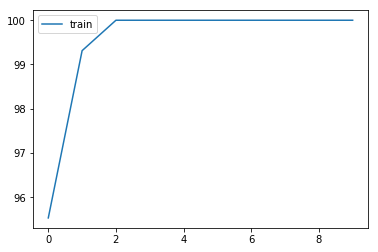

In [8]:
# Fonction ptest qui évalue un x selon un theta
def ptest(x, theta):
    # Ajout du 1 à chaque x
    npx = np.insert(np.array(x), nb_features, 1, axis=1)

    # On met theta comme il faut
    theta = theta.reshape((1, nb_features+1))
    
    # Calcul
    v = np.dot(theta, npx.T)

    # On applique la fonction signe
    v = np.sign(v)
    
    return v[0][0]

# Fonction ptrain
error_train = []

def ptrain_v2(X_train, c_train, iterations):    
    history = []
    theta = np.array([np.random.random() for _ in range(nb_features+1)])

    for _ in range(iterations):
        for i in range(len(c_train)):
            x = [X_train[j][i] for j in range(nb_features)]
            c = ptest([x], theta)

            # Erreur
            if (c == 1 and c_train[i] == -1) or (c == -1 and c_train[i] == 1):
                theta -= c * np.concatenate((np.array(x),np.array([1])))

        # Calcul de l'erreur
        cpt = 0
        for i in range(len(c_train)):
            x = [X_train[j][i] for j in range(nb_features)]
            c = ptest([x], theta)
            
            if (c == 1 and c_train[i] == 1) or (c == -1 and c_train[i] == -1):
                cpt += 1
        
        cpt = (cpt/len(c_train))*100
        error_train.append(cpt)
        history.append((cpt, theta.copy()))


    plt.plot(error_train, label='train')
    plt.legend()
    plt.show()
    
    return list(reversed(sorted(history, key=lambda x : x[0])))[0][1]

theta = ptrain_v2(t[0][0], t[1][0], 10)